In [3]:
import torch
from sklearn.metrics import precision_recall_fscore_support
from test_data import GraphDatasetEdgesTest
from data6 import GraphDatasetEdgesAndNodesWithNegativeSamplesTest
#from basic_data import GraphDatasetBasic
from torch_geometric.loader import DataLoader
from baseline_models import GINSubgraphModel
from models import Graph2Cone, Graph2Cone_hybrid, cone_loss, d_con3
from tqdm.auto import tqdm
import numpy as np
import networkx as nx
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json

In [36]:
from util import *
image_ids_with_coco_captions_with_nodes = utilfunc_read_pickle_to_list("helper_files/image_ids_with_coco_captions_with_nodes.pickle")
print(len(image_ids_with_coco_captions_with_nodes))

50783


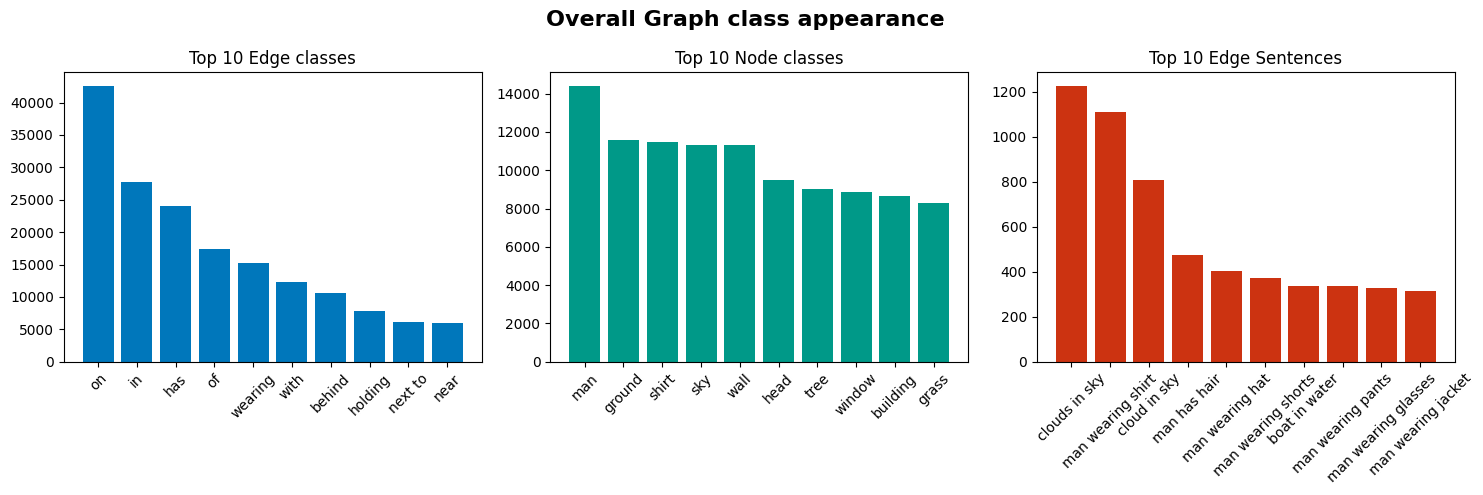

In [3]:
with open("edge_histogram.json") as f:
    edge_histogram = json.load(f)
with open("node_histogram.json", "r") as f:
    node_histogram = json.load(f)
with open("edge_sentence_histogram.json", "r") as f:
    edge_sentence_histogram = json.load(f)

# Function to get top 10 items
def get_top_10(histogram):
    # Sort the dictionary by value and get the top 10
    return sorted(histogram.items(), key=lambda x: x[1], reverse=True)[:10]

def get_bottom_10(histogram):
    # Sort the dictionary by value and get the top 10
    return sorted(histogram.items(), key=lambda x: x[1], reverse=False)[:10]

# Get the top 10 items from each histogram
top_edge = get_top_10(edge_histogram)
top_node = get_top_10(node_histogram)
top_edge_sentence = get_top_10(edge_sentence_histogram)

#top_edge = get_bottom_10(edge_histogram)
#top_node = get_bottom_10(node_histogram)
#top_edge_sentence = get_bottom_10(edge_sentence_histogram)

# Splitting the data into labels and values for plotting
edge_labels, edge_values = zip(*top_edge)
node_labels, node_values = zip(*top_node)
edge_sentence_labels, edge_sentence_values = zip(*top_edge_sentence)

# Plotting the data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(edge_labels, edge_values, color='#0077BB')
axes[0].set_title('Top 10 Edge classes')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(node_labels, node_values, color='#009988')
axes[1].set_title('Top 10 Node classes')
axes[1].tick_params(axis='x', rotation=45)

axes[2].bar(edge_sentence_labels, edge_sentence_values, color='#CC3311')
axes[2].set_title('Top 10 Edge Sentences')
axes[2].tick_params(axis='x', rotation=45)

# Adding an overall title
plt.suptitle('Overall Graph class appearance', fontsize=16, fontweight='bold')


plt.tight_layout()
plt.savefig("histograms_train_validation.png")
plt.show()
plt.close()

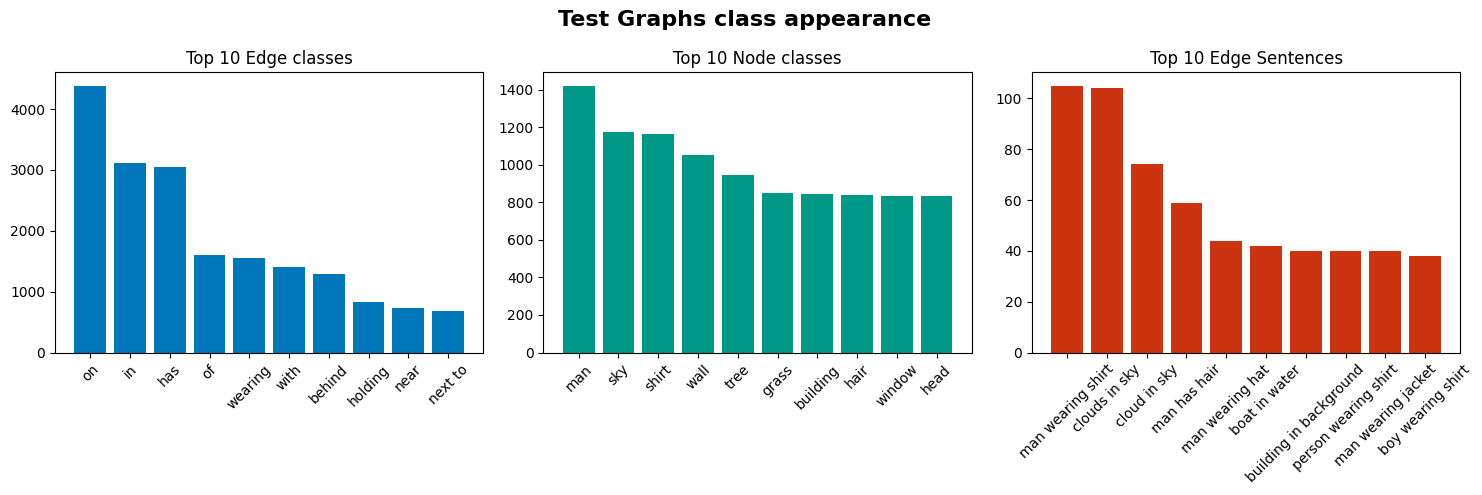

In [4]:
with open("edge_histogram_test.json") as f:
    edge_histogram = json.load(f)
with open("node_histogram_test.json", "r") as f:
    node_histogram = json.load(f)
with open("edge_sentence_histogram_test.json", "r") as f:
    edge_sentence_histogram = json.load(f)

# Function to get top 10 items
def get_top_10(histogram):
    # Sort the dictionary by value and get the top 10
    return sorted(histogram.items(), key=lambda x: x[1], reverse=True)[:10]

def get_bottom_10(histogram):
    # Sort the dictionary by value and get the top 10
    return sorted(histogram.items(), key=lambda x: x[1], reverse=False)[:10]

# Get the top 10 items from each histogram
top_edge = get_top_10(edge_histogram)
top_node = get_top_10(node_histogram)
top_edge_sentence = get_top_10(edge_sentence_histogram)

#top_edge = get_bottom_10(edge_histogram)
#top_node = get_bottom_10(node_histogram)
#top_edge_sentence = get_bottom_10(edge_sentence_histogram)


# Splitting the data into labels and values for plotting
edge_labels, edge_values = zip(*top_edge)
node_labels, node_values = zip(*top_node)
edge_sentence_labels, edge_sentence_values = zip(*top_edge_sentence)

# Plotting the data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(edge_labels, edge_values, color='#0077BB')
axes[0].set_title('Top 10 Edge classes')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(node_labels, node_values, color='#009988')
axes[1].set_title('Top 10 Node classes')
axes[1].tick_params(axis='x', rotation=45)

axes[2].bar(edge_sentence_labels, edge_sentence_values, color='#CC3311')
axes[2].set_title('Top 10 Edge Sentences')
axes[2].tick_params(axis='x', rotation=45)

# Adding an overall title
plt.suptitle('Test Graphs class appearance', fontsize=16, fontweight='bold')


plt.tight_layout()
plt.savefig("histograms_test.png")
plt.show()
plt.close()

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#basic_dataset = GraphDatasetBasic()[-5000:]
#test_dataset = GraphDatasetEdgesTest()
test_dataset = GraphDatasetEdgesAndNodesWithNegativeSamplesTest(root="harder_graph_dataset_edges_and_nodes_negative_samples_test_large")
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


NameError: name 'torch' is not defined

In [3]:
def f1(TP, FP, FN):
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    if precision + recall == 0:
        return precision, recall, 0
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

In [1]:
def plot_graphs_side_by_side(g, q, n, title_g='Graph', title_q='Query', title_n='Negative'):
    """
    Plots two graphs side by side in a single figure.

    Parameters:
    - g (nx.Graph): First graph to plot.
    - q (nx.Graph): Second graph to plot.
    - title_g (str): Title of the first graph.
    - title_q (str): Title of the second graph.
    """
    # Set up the subplot environment
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 2 columns

    # Helper function to draw each graph
    def draw_graph(graph, ax, title):
        pos = nx.spring_layout(graph)  # positions for all nodes
        nx.draw_networkx_nodes(graph, pos, ax=ax, node_color='#0077BB', node_size=100)
        nx.draw_networkx_labels(graph, pos, ax=ax, labels={node: data['classes'] for node, data in graph.nodes(data=True)}, font_size=8)
        nx.draw_networkx_edges(graph, pos, ax=ax)
        nx.draw_networkx_edge_labels(graph, pos, ax=ax, edge_labels={(src, dst): data['classes'] for src, dst, data in graph.edges(data=True)}, font_size=8)
        ax.set_title(title)

    # Draw both graphs
    draw_graph(g, axes[0], title_g)
    draw_graph(q, axes[1], title_q)
    draw_graph(n, axes[2], title_n)


    plt.tight_layout()
    plt.savefig("graphs.png")

q, g, q_text, g_text, negatives, imgidx, datidx = test_dataset[0]
_, n_text, _ = negatives[0]
plot_graphs_side_by_side(g_text, q_text, n_text)

NameError: name 'test_dataset' is not defined

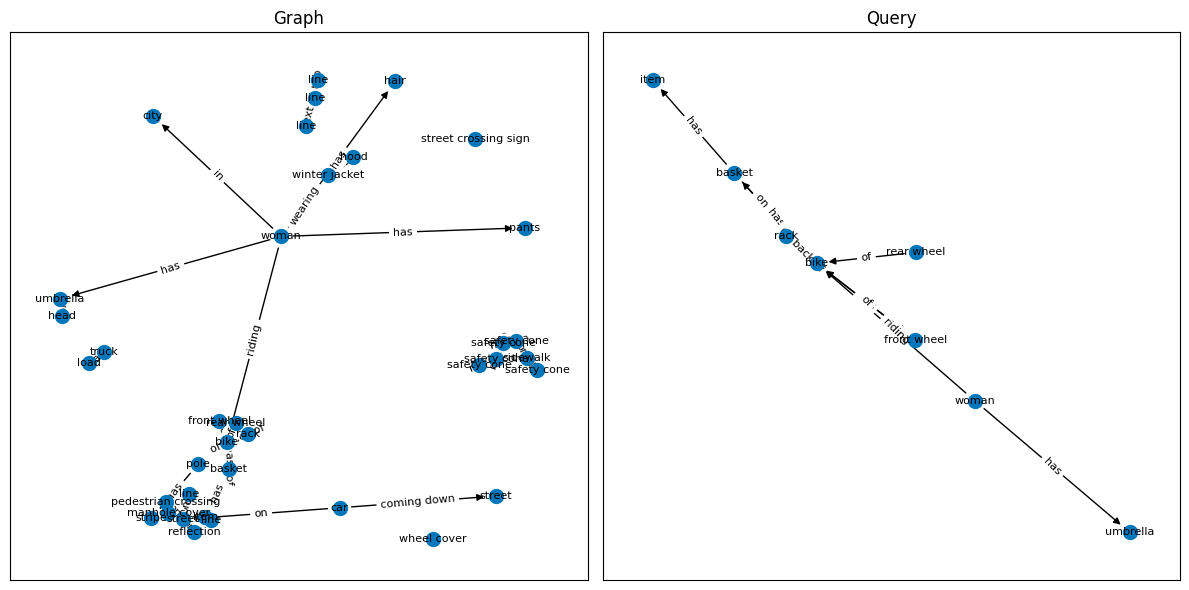

In [20]:

q, g, q_text, g_text, negatives, imgidx, datidx = test_dataset[427]
plot_graphs_side_by_side(g_text, q_text)

In [23]:
def jaccard_distance(set1, set2):
    intersection = set1 & set2 
    union = set1 | set2
    if len(union) == 0:
        return 0
    return len(intersection) / len(union)

def jaccard_distance2(set1, set2):
    intersection = set1 & set2 
    union = set1 | set2
    if len(union) == 0:
        return 0
    return len(intersection) / len(set1)

true_positives = []
false_positives = []
false_negatives = []
n = len(test_dataset)
for q_id in tqdm(range(n), total=n):
    _, _, query, graph, negatives, _, _  = test_dataset[q_id]
    q_node_map = {i: c for i, c in query.nodes(data="classes")}
    q_edge_labels = [f"{q_node_map[f]} {edge_attr} {q_node_map[t]}"  for f, t, edge_attr in query.edges(data="classes")]
    q_edge_labels = [f"{edge_attr}"  for f, t, edge_attr in query.edges(data="classes")]
    q_edge_set = set(q_edge_labels)
    jacc_distances = []
    #jacc_distances2 = []
    gs = [graph] + [g for _, g, _ in negatives]
    labels = [1] + [0 for _ in negatives]
    for g in gs:
        g_node_map = {i: c for i, c in g.nodes(data="classes")}
        #g_edge_labels = [f"{g_node_map[f]} {edge_attr} {g_node_map[t]}"  for f, t, edge_attr in g.edges(data="classes")]
        g_edge_labels = [f"{edge_attr}"  for f, t, edge_attr in g.edges(data="classes")]
        g_edge_set = set(g_edge_labels)
        distance = jaccard_distance(q_edge_set, g_edge_set)
        distance2 = jaccard_distance2(q_edge_set, g_edge_set)
        jacc_distances.append(distance)
        #jacc_distances2.append(distance2)

    jacc_distances = np.array(jacc_distances)
    #jacc_distances2 = np.array(jacc_distances2)
    max_dist_idx = np.random.choice(np.flatnonzero(jacc_distances == jacc_distances.max()))
    if max_dist_idx == 0:
        true_positives.append(q_id)
    else:
        false_positives.append(q_id)
        false_negatives.append(q_id)

precision, recall, f1_score = f1(len(true_positives), len(false_positives), len(false_negatives))
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Precision: 0.38, Recall: 0.38, F1 Score: 0.38


In [9]:
from torch_geometric import data
from torch_geometric.loader import DataLoader
class WithoutTheTextGraphs(data.Dataset):
    def __init__(self, data):
        self.data = data
        super().__init__()

    def len(self):
        return len(self.data)

    def get(self, idx):
        # Extract only the PyTorch graphs, image_id, boolean label, and data index from each tuple
        q2, q1, _, _, negatives, image_idx, data_idx = self.data[idx]
        negatives = [g for g, _, _ in negatives]
        #print(type(q2), type(q1), type(image_idx), type(q_type), type(data_idx))
        return q2, q1, negatives, image_idx, data_idx
    
without_the_text_graphs = WithoutTheTextGraphs(test_dataset)
test_loader = DataLoader(without_the_text_graphs, batch_size=1, shuffle=False)

In [86]:
def calculate_f1_score_baseline(model, dataloader):

    error_histogram = dict()
    true_positives = []
    false_positives = []
    false_negatives = []
    # Ensure the model is in eval mode
    model.eval()
    # Forward pass
    with torch.no_grad():
        for q2, q1, negatives, image_idx, data_idx in tqdm(dataloader):

            q2 = q2.to(device)
            q1 = q1.to(device)
            distances = []
            gs = [q1] + [g.to(device) for g in negatives]
            labels = [1] + [0 for _ in negatives]
            for g in gs:
                output = model(q2, g)
                distances.append(output.item())

            distances = np.array(distances)
            max_dist_idx = np.random.choice(np.flatnonzero(distances == distances.max()))
            if max_dist_idx == 0:
                true_positives.append(q_id)
            else:
                false_positives.append(q_id)
                false_negatives.append(q_id)
    # Calculate precision, recall, and F1 score
    precision, recall, f1_score = f1(len(true_positives), len(false_positives), len(false_negatives))
    return precision, recall, f1_score, error_histogram

# Assuming `data` is your dataset for evaluation
#baseline

#load model
#model = GINSubgraphModel(256, 256)
path = "Graph2Cone_baseline_saved_files/Graph2Cone_baseline_full_model_2024-04-26_01-25-20.pt"
model = torch.load(path, map_location=torch.device(device))


precision1, recall1, f1_score1, error_histogram1 = calculate_f1_score_baseline(model, test_loader)
print(f"Precision: {precision1}, Recall: {recall1}, F1 Score: {f1_score1}")
#print(error_histogram1)


  0%|          | 0/1000 [00:00<?, ?it/s]

Precision: 0.3, Recall: 0.3, F1 Score: 0.3


In [16]:
def sine_halves(theta):
    return torch.sin(theta / 2)

def d_outside(V_q1, V_q2):
    theta_ax1, ap1 = V_q1
    theta_ax2, ap2 = V_q2
    theta_ap1 = ap1 / 2
    theta_ap2 = ap2 / 2
    
    theta_L1 = theta_ax1 - theta_ap1
    theta_U1 = theta_ax1 + theta_ap1
    theta_L2 = theta_ax2 - theta_ap2
    theta_U2 = theta_ax2 + theta_ap2

    distanceU2axis = torch.abs(sine_halves(theta_U1 - theta_ax2))
    distanceL2axis = torch.abs(sine_halves(theta_L1 - theta_ax2))
    distanceax2axis = torch.abs(sine_halves(theta_ax1 - theta_ax2))
    distance_base = torch.abs(sine_halves(theta_ap2))

    indicator_U_in = distanceU2axis < distance_base
    indicator_L_in = distanceL2axis < distance_base
    indicator_axis_in = distanceax2axis < distance_base

    distance_U_out = torch.min(torch.abs(sine_halves(theta_U1 - theta_U2)), torch.abs(sine_halves(theta_U1 - theta_L2)))
    distance_L_out = torch.min(torch.abs(sine_halves(theta_L1 - theta_L2)), torch.abs(sine_halves(theta_L1 - theta_U2)))
    distance_axis_out = torch.min(torch.abs(sine_halves(theta_ax1 - theta_L2)), torch.abs(sine_halves(theta_ax1 - theta_U2)))

    distance_U_out[indicator_U_in] = 0
    distance_L_out[indicator_L_in] = 0
    distance_axis_out[indicator_axis_in] = 0

    distance_out = distance_U_out + distance_L_out + distance_axis_out
    return distance_out

def d_inside(V_q1, V_q2):
    theta_ax1, ap1 = V_q1
    theta_ax2, ap2 = V_q2
    theta_ap1 = ap1 / 2
    theta_ap2 = ap2 / 2
    
    theta_L1 = theta_ax1 - theta_ap1
    theta_U1 = theta_ax1 + theta_ap1
    theta_L2 = theta_ax2 - theta_ap2
    theta_U2 = theta_ax2 + theta_ap2

    distanceU2axis = torch.abs(sine_halves(theta_U1 - theta_ax2))
    distanceL2axis = torch.abs(sine_halves(theta_L1 - theta_ax2))
    distanceax2axis = torch.abs(sine_halves(theta_ax1 - theta_ax2))
    distance_base = torch.abs(sine_halves(theta_ap2))

    distance_U_in = torch.norm(torch.min(distanceU2axis, distance_base), p=1, dim=-1)
    distance_L_in = torch.norm(torch.min(distanceL2axis, distance_base), p=1, dim=-1)
    distance_axis2axis = torch.norm(torch.min(distance_base, distanceax2axis), p=1, dim=-1)

    distance_in = distance_U_in + distance_L_in + distance_axis2axis

    return distance_in

def d_outside2(V_q1, V_q2):
    theta_ax1, ap1 = V_q1
    theta_ax2, ap2 = V_q2
    theta_ap1 = ap1 / 2
    theta_ap2 = ap2 / 2
    
    theta_L2 = theta_ax2 - theta_ap2
    theta_U2 = theta_ax2 + theta_ap2

    distanceax2axis = torch.abs(sine_halves(theta_ax1 - theta_ax2))
    distance_base = torch.abs(sine_halves(theta_ap2))

    indicator_axis_in = distanceax2axis < distance_base
    distance_axis_out = torch.min(torch.abs(sine_halves(theta_ax1 - theta_L2)), torch.abs(sine_halves(theta_ax1 - theta_U2)))
    distance_axis_out[indicator_axis_in] = 0

    distance_out = distance_axis_out
    distance = distance_out
    return distance

def d_inside2(V_q1, V_q2):
    theta_ax1, ap1 = V_q1
    theta_ax2, ap2 = V_q2
    theta_ap1 = ap1 / 2
    theta_ap2 = ap2 / 2

    distanceax2axis = torch.abs(sine_halves(theta_ax1 - theta_ax2))
    distance_base = torch.abs(sine_halves(theta_ap2))

    distance_axis2axis = torch.norm(torch.min(distance_base, distanceax2axis), p=1, dim=-1)
    distance_in = distance_axis2axis

    distance = distance_in
    return distance

In [31]:
import torch.nn.functional as F
def calculate_f1_score_cone(model, answer_model, dataloader, threshold=256):
    # Ensure the model is in eval mode
    model.eval()
    answer_model.eval()
    
    # Forward pass
    with torch.no_grad():
        true_positives = []
        false_positives = []
        false_negatives = []
        q_graphs = []
        g_graphs = []
        distances = []
        neg_distances = []
        predictions = []
        queries = []
        graphs = []
        negative_graphs = []
        error_histogram = dict()
        positives_contained = 0
        negatives_contained = 0
        t1 = []
        t2 = []
        for q2, q1, negatives, img_idx, data_idx in tqdm(dataloader):
            
            q2 = q2.to(device)
            q1 = q1.to(device)
            conea = model(q1.x, q1.edge_index, q1.edge_attr, q1.batch, is_query=False)
            coneb = model(q2.x, q2.edge_index, q2.edge_attr, q2.batch)
            queries.append(coneb)
            graphs.append(conea)

            distance_out = d_outside(conea, coneb)
            #distance_in = d_inside(conea, coneb)
            #count how many elements in distnace_out are less than gamma
            fully_inside = torch.sum(distance_out <= 0).item()
            t1.append(fully_inside)
            if fully_inside >= threshold:
                positives_contained += 1
            n_dists = []
            t3 = []
            for g in negatives:
                g = g.to(device)
                conec = model(g.x, g.edge_index, g.edge_attr, g.batch, is_query=False)
                negative_graphs.append(conec)
                neg_distance_out = d_outside(conec, coneb)
                #neg_distance_in = d_con3(conec, coneb)
                fully_inside = torch.sum(neg_distance_out <= 0).item()
                t3.append(fully_inside)
                if fully_inside >= threshold:
                    negatives_contained += 1
                    

                #predictions.append((neg_distance_out <= gamma).item())
                n_dists.append(neg_distance_out)
            neg_distances.append(n_dists)
            t2.append(t3)

            distances.append(distance_out)
            q_graphs.append(q2)
            g_graphs.append(q1)

        print(f"Positives contained: {positives_contained}, Negatives contained: {negatives_contained}")
        print(f"Average positives contained: {np.mean(t1)}, Average negatives contained: {np.mean([np.mean(x) for x in t2])}")

        print(f"True Positives: {len(true_positives)}, False Positives: {len(false_positives)}, False Negatives: {len(false_negatives)}")
        #precision, recall, f1_score = f1(len(true_positives), len(false_positives), len(false_negatives))
        #print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")

        return queries, graphs, distances, q_graphs, g_graphs, error_histogram, neg_distances, negative_graphs
    

#path = "Graph2Cone_saved_files/Graph2Cone_full_model_2024-05-07_15-08-02.pt" gamma=36
#path  = "Graph2Cone_saved_files/Graph2Cone_full_model_2024-05-07_13-08-17.pt"
#path  = "Graph2Cone_saved_files/Graph2Cone_full_model_2024-05-08_11-30-14.pt"
#path = "Graph2Cone_saved_files/Graph2Cone_really_skewed_full_model_2024-05-09_09-42-59.pt"
#path = "Graph2Cone_saved_files/Graph2Cone_finetuning_0_full_model_2024-05-09_11-56-30.pt" #
#path = "Graph2Cone_saved_files/Graph2Cone_finetuning_0_full_model_2024-05-09_11-22-14.pt"
#path = "Graph2Cone_saved_files/Graph2Cone_finetuned_skewed_full_model_2024-05-09_21-45-27.pt"
#path = "Graph2Cone_saved_files/Graph2Cone_skewed1_full_model_2024-05-10_13-51-04.pt" # lamb=0.2, pos_gamma=6, neg_gamma=36
#path = "Graph2Cone_saved_files/Graph2Cone_really_skewed_full_model_2024-05-09_09-42-59.pt" # lamb=0.5, pos_gamma=1, neg_gamma=256
path = "Graph2Cone_saved_files/Graph2Cone14_full_model_2024-05-12_23-51-02.pt" #
model = torch.load(path, map_location=torch.device(device))
answer_model_path = "Answer2Cone_saved_files_new/Graph2Cone13_relu_full_model_2024-05-13_08-01-41.pt"
answer_model = torch.load(answer_model_path, map_location=torch.device(device))

queries, graphs, distances, q_graphs, g_graphs, error_histogram, neg_distances, negative_graphs  = calculate_f1_score_cone(model, answer_model, test_loader)

#hybrid: Precision: 0.5095360091090236, Recall: 0.3726061615320566, F1 Score: 0.4304436695924011
#not hybrid: Precision: 0.49395581492288454, Recall: 0.24666944213155703, F1 Score: 0.3290295710120783
#~6m 5s

  0%|          | 0/1000 [00:00<?, ?it/s]

Positives contained: 1, Negatives contained: 0
Average positives contained: 223.041, Average negatives contained: 182.17684999999997
True Positives: 0, False Positives: 0, False Negatives: 0


In [29]:
#check model weights
path = "Answer2Cone_saved_files_new/Graph2Cone12_full_model_2024-05-13_07-58-40.pt" #
model = torch.load(path, map_location=torch.device(device))

def print_grad_norms(model):
    for name, parameter in model.named_parameters():
        #print(parameter[0][0])
        if parameter[0] is not None:
            norm = parameter[0].norm()
            if norm <= 1e-4:  # Set a small threshold value
                print(f"Small gradient norm detected in {name}: {norm}")
print_grad_norms(model)

Small gradient norm detected in conv1.bias: 6.791897612856701e-05
Small gradient norm detected in conv2.bias: 9.431038779439405e-05


In [102]:
predictions = torch.cat(distances) <= 2.19#0 #5.486e-05
count = 0
count_pos = 0
count_neg = 0
mistake_indices = []
for i, (l, p, d) in enumerate(zip(true_labels, predictions, distances)):
    if p != l:
        mistake_indices.append(i)
        #print(f"Query: {q}")
        #print(f"Graph: {g}")
        #print(f"True Label: {l}")
        #print(f"Distance: {d}")
        count += 1
        if l == 1:
            count_pos += 1
        else:
            count_neg += 1
print("Errors:", count)
print("positive errors:", count_pos)
print("negative errors:", count_neg)
print(mistake_indices)

Errors: 76
positive errors: 76
negative errors: 0
[20, 23, 45, 61, 77, 79, 109, 132, 144, 147, 164, 168, 173, 175, 176, 194, 195, 202, 218, 219, 226, 246, 260, 267, 274, 285, 286, 290, 296, 330, 331, 340, 361, 364, 365, 385, 415, 444, 458, 463, 510, 511, 519, 520, 521, 542, 547, 570, 621, 623, 635, 647, 651, 670, 674, 675, 690, 700, 732, 733, 734, 756, 778, 783, 806, 807, 841, 864, 885, 906, 915, 919, 954, 958, 965, 966]


In [23]:
mean_distance = torch.mean(torch.cat(distances))
median = torch.median(torch.cat(distances))
std_distance = torch.std(torch.cat(distances))
print(mean_distance)
print(std_distance)
print(median)
print(torch.max(torch.cat(distances)))
print(torch.min(torch.cat(distances)))

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


In [22]:
flattened_neg_distances = [x for sublist in neg_distances for x in sublist]

mean_distance = torch.mean(torch.cat(flattened_neg_distances))
median = torch.median(torch.cat(flattened_neg_distances))
std_distance = torch.std(torch.cat(flattened_neg_distances))
min_distance = torch.min(torch.cat(flattened_neg_distances))
max_distance = torch.max(torch.cat(flattened_neg_distances))
print(mean_distance)
print(std_distance)
print(median)
print(min_distance)
print(max_distance)

tensor(1.6609e-05)
tensor(0.0027)
tensor(0.)
tensor(0.)
tensor(1.3323)


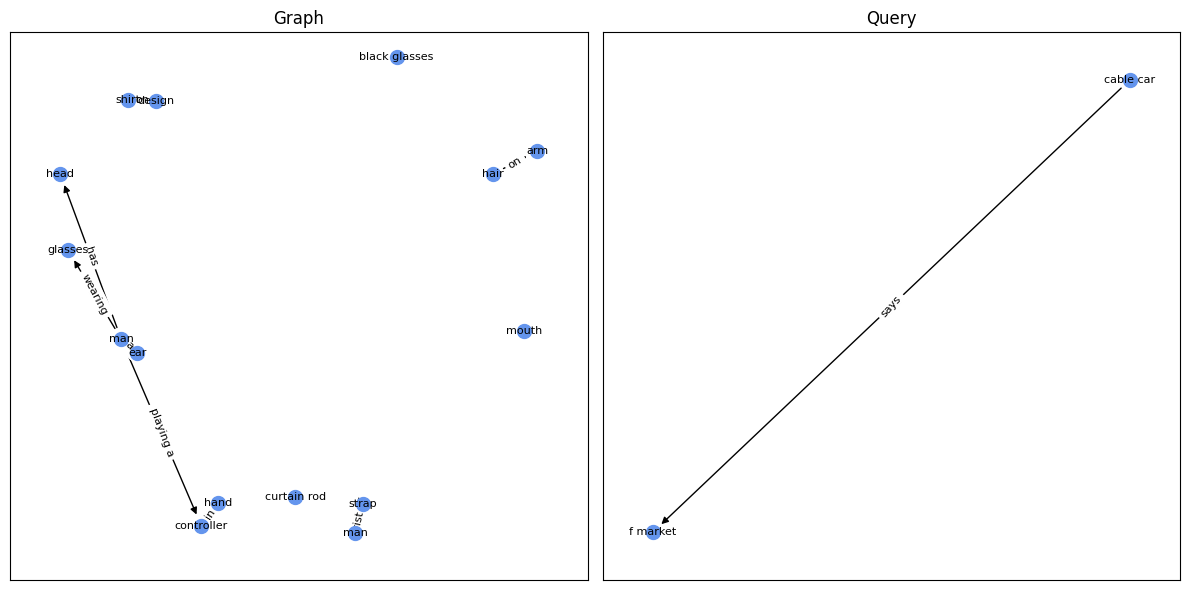

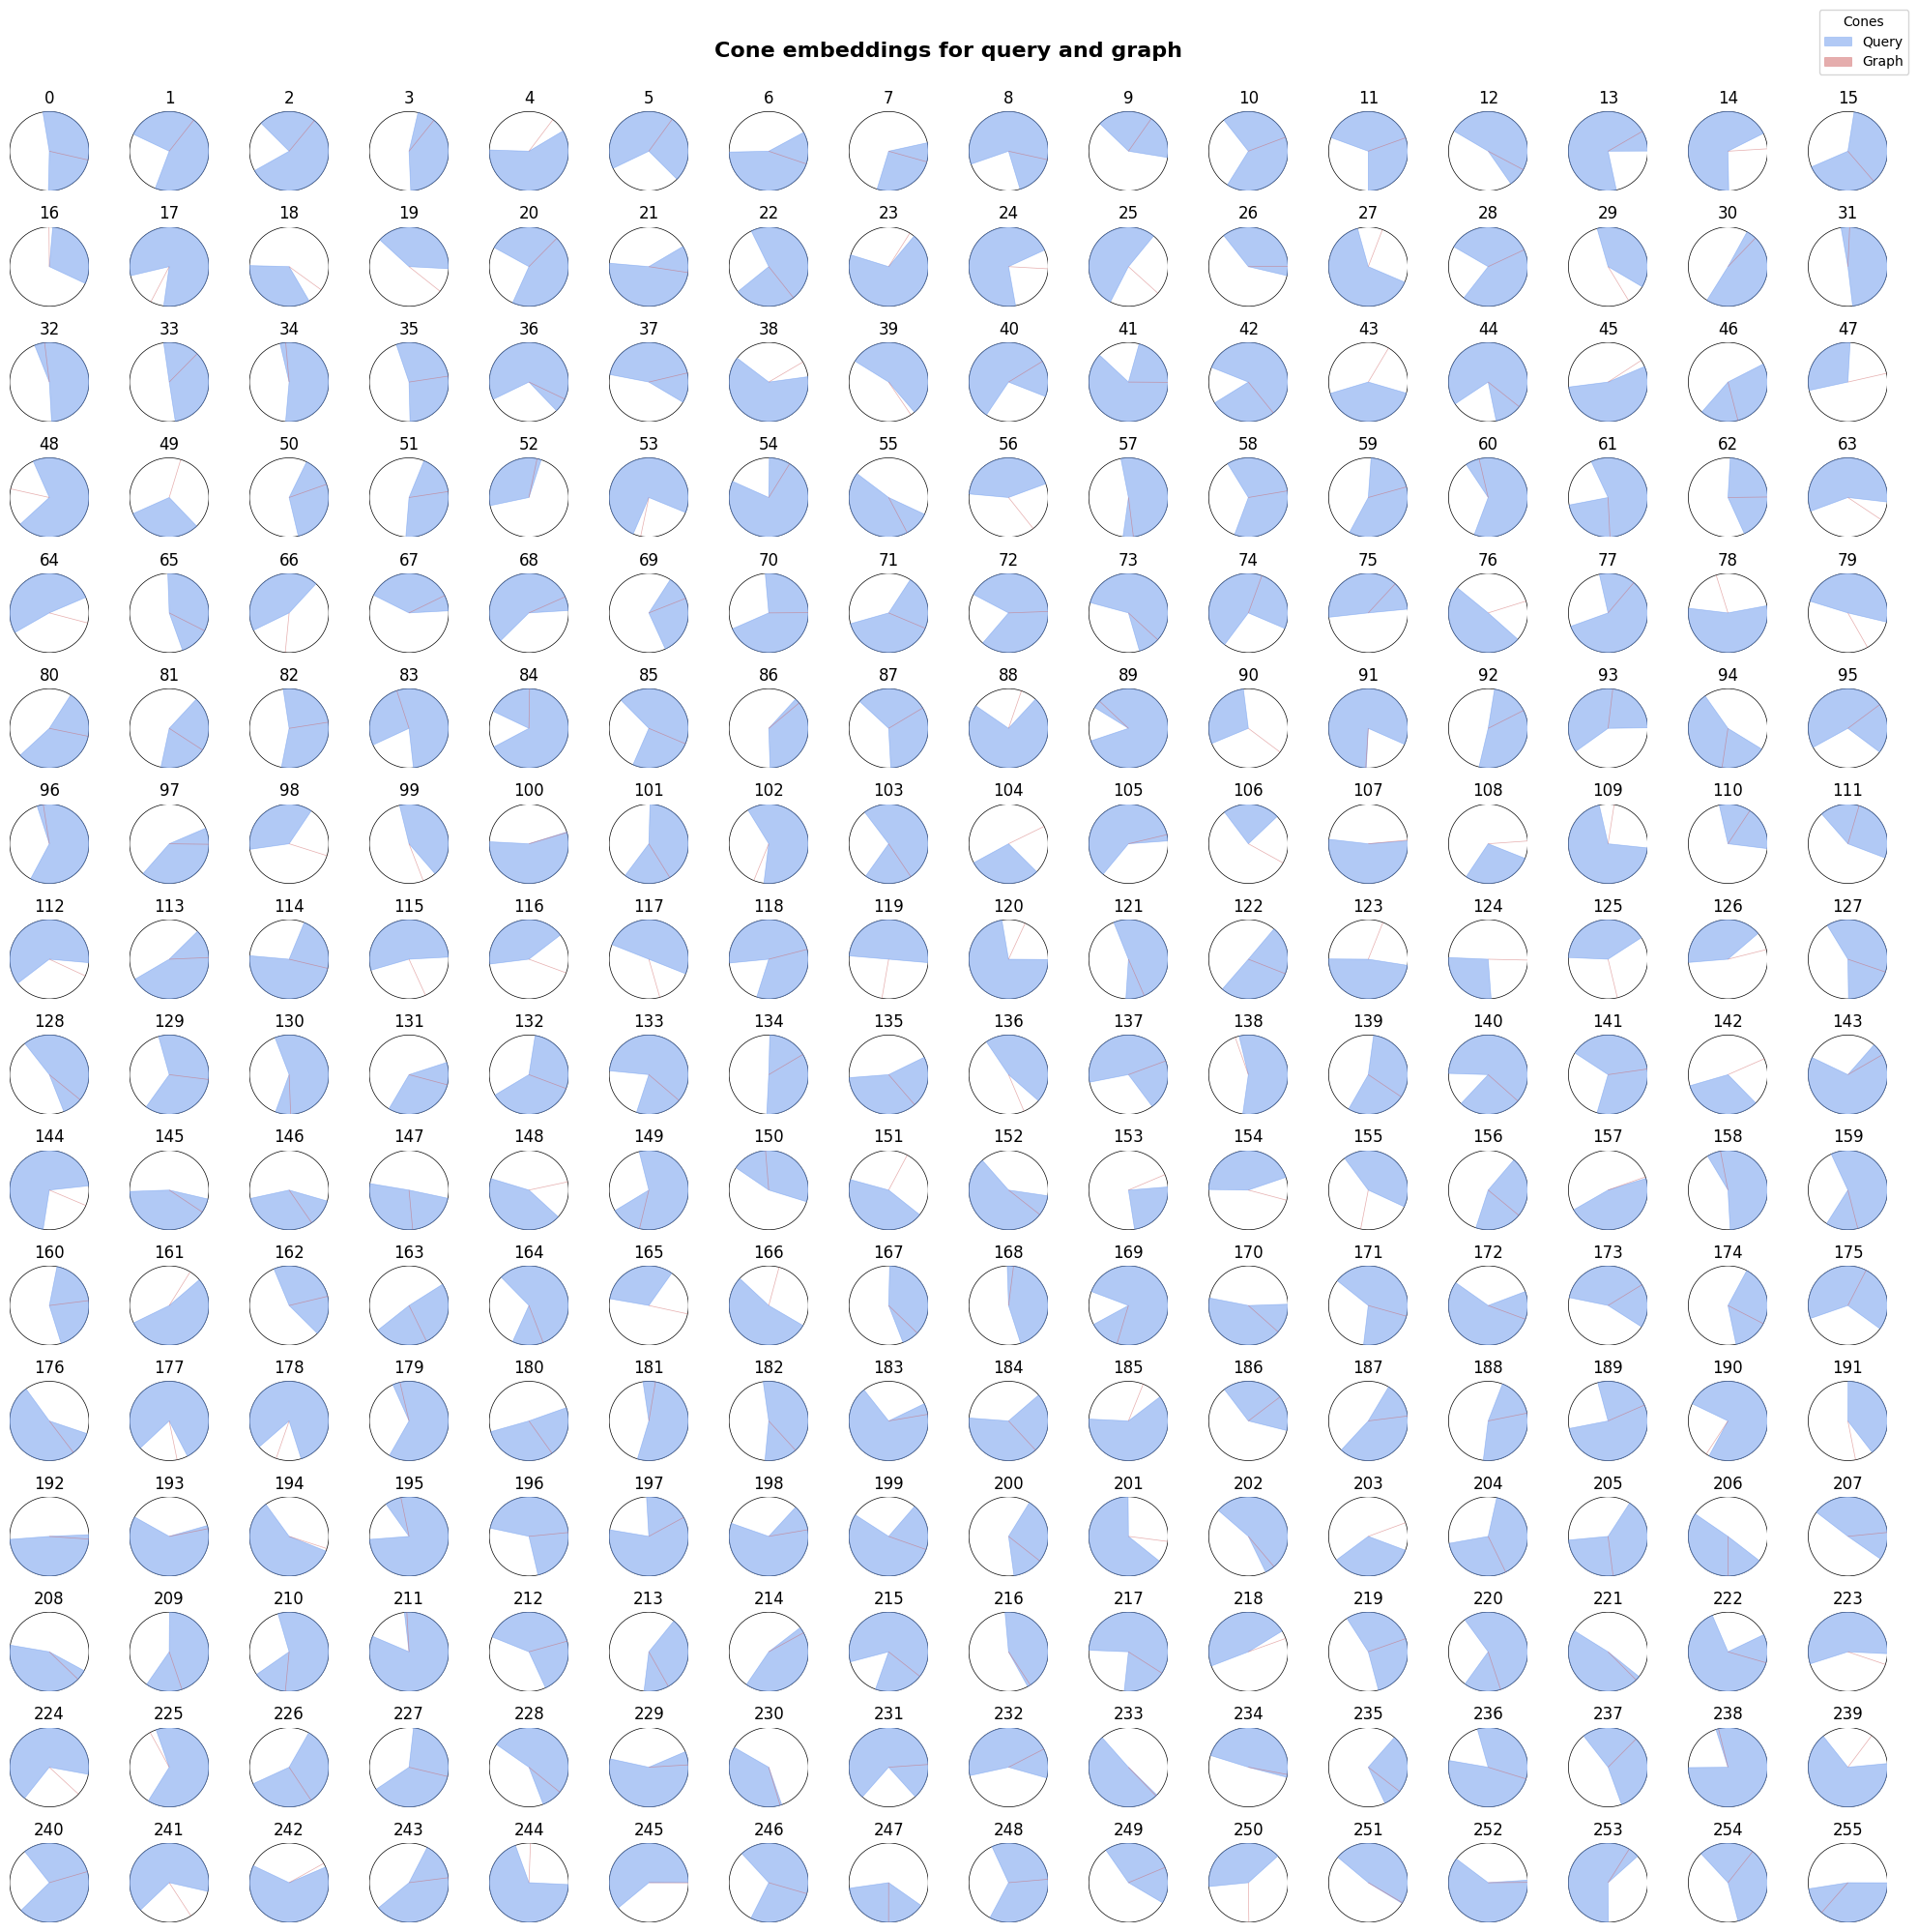

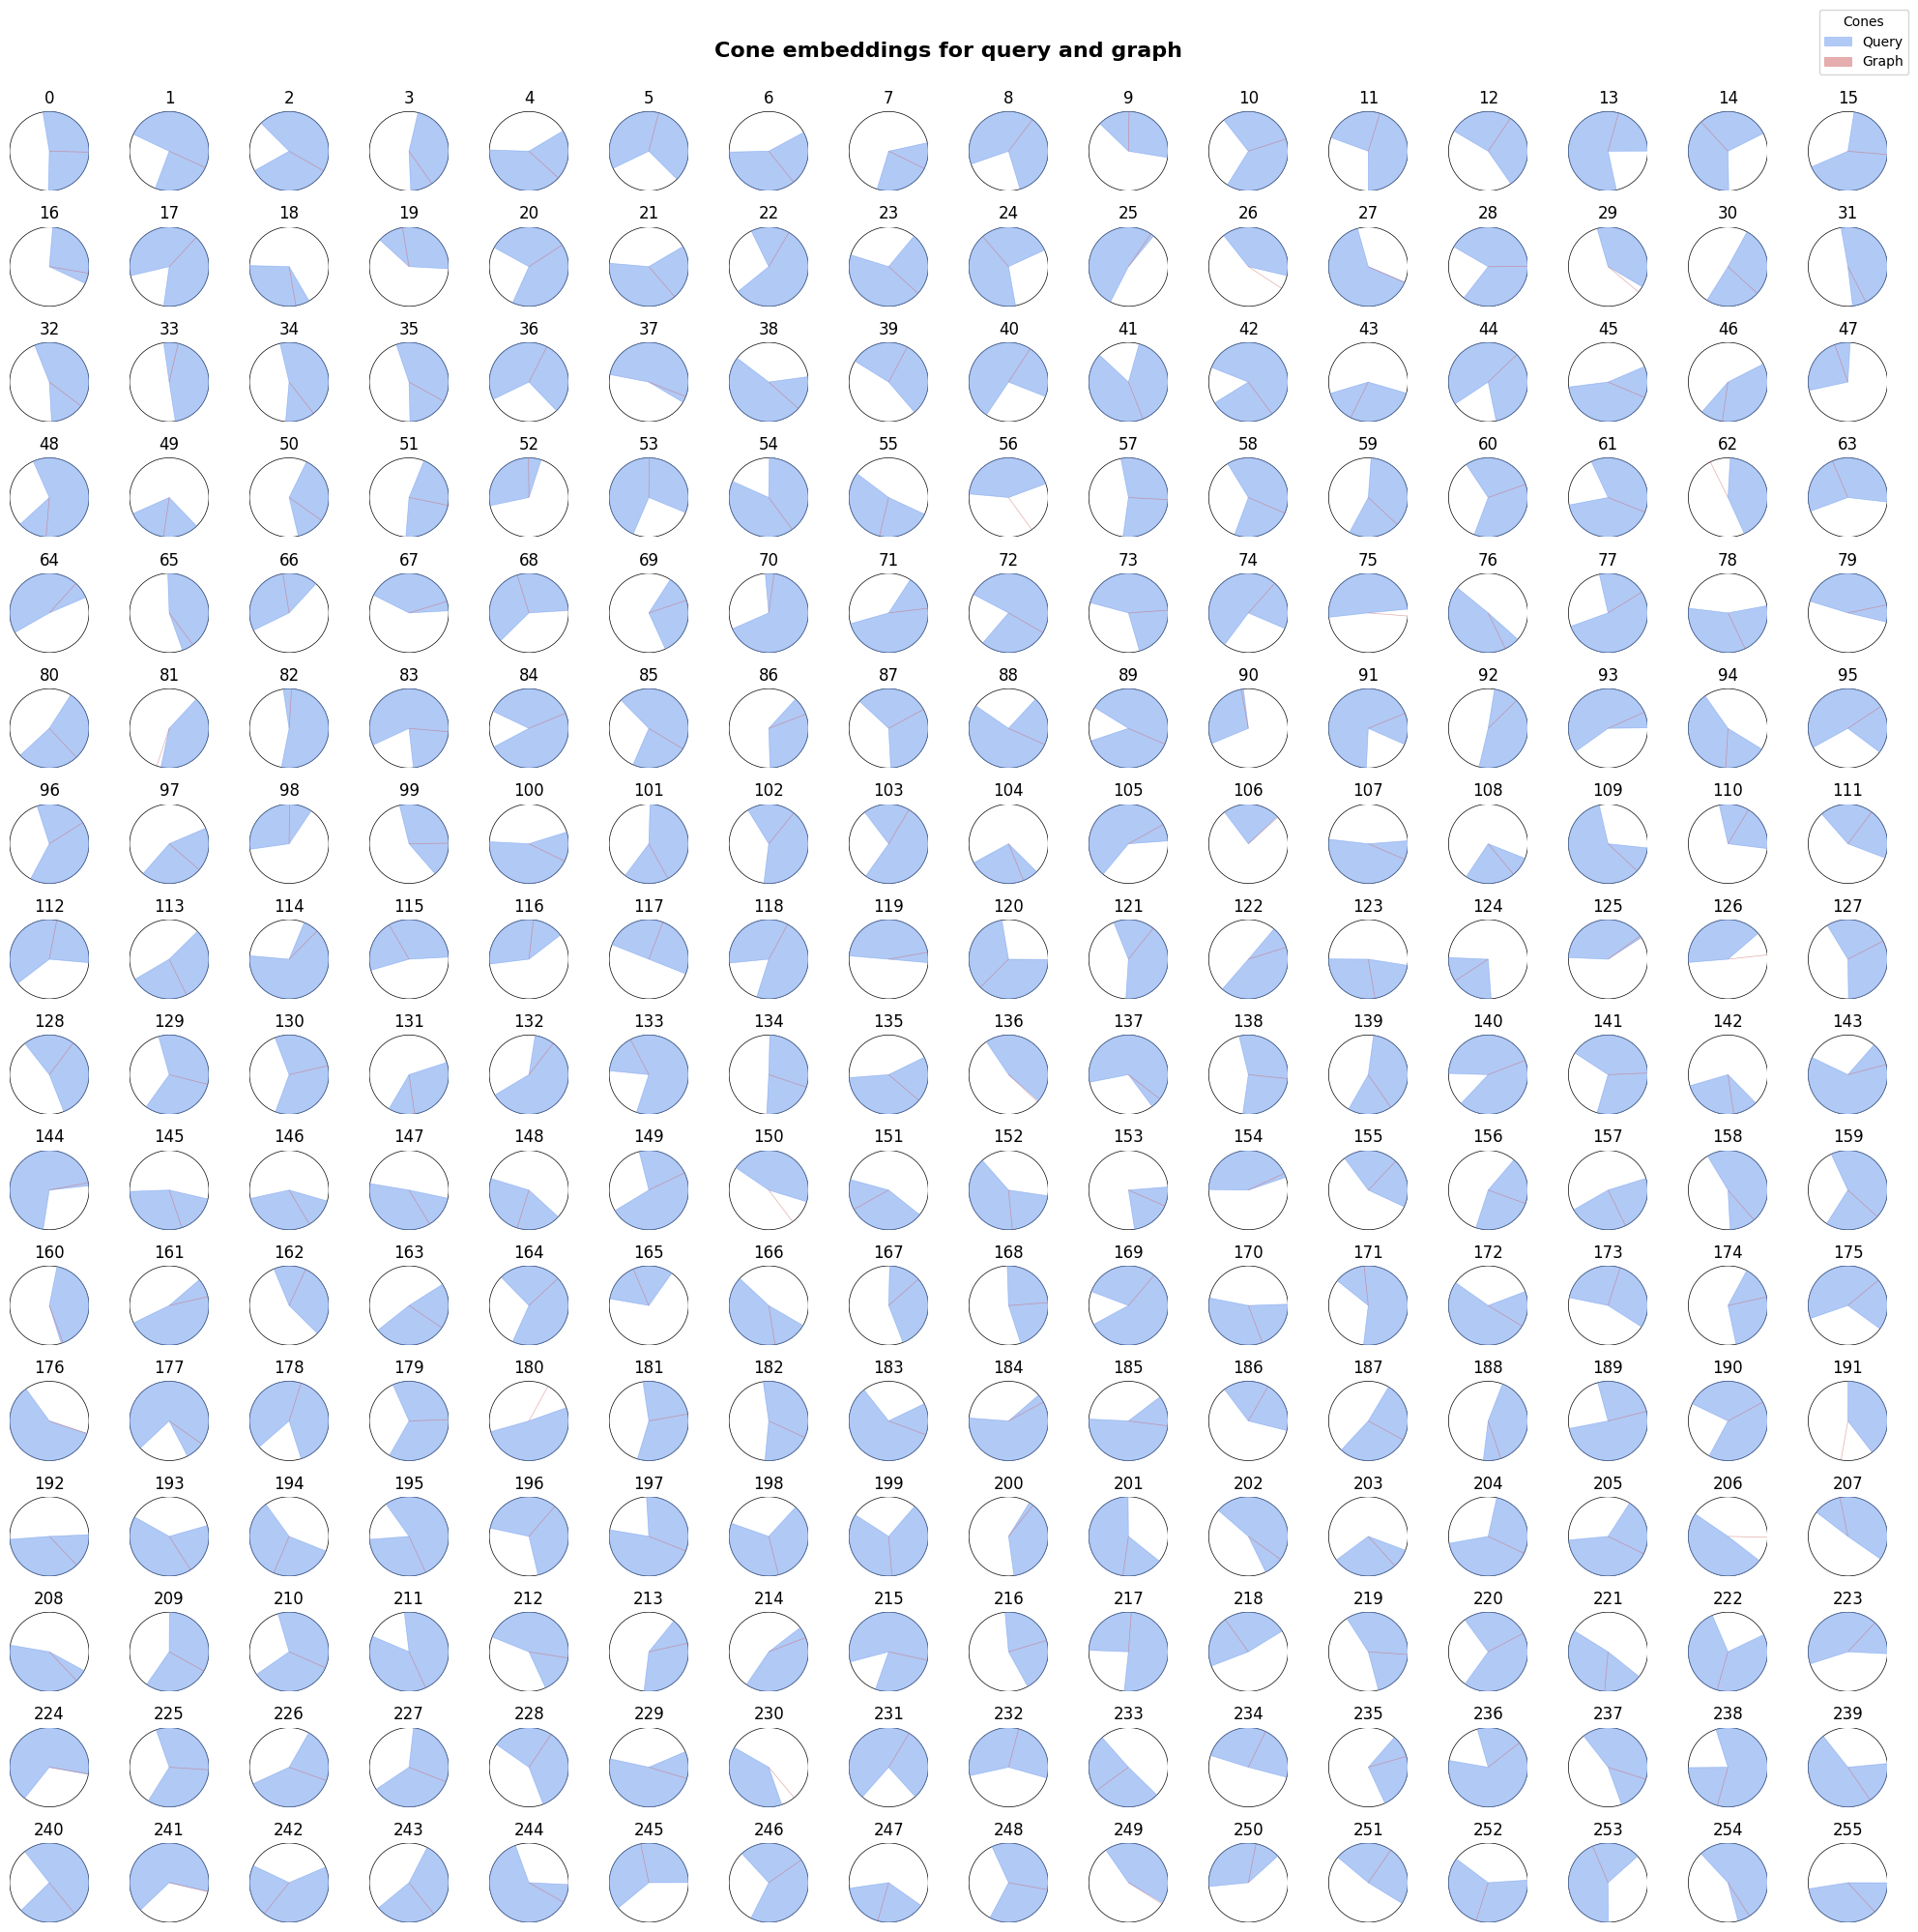

In [32]:
idx = 0
query = queries[idx]
graph = graphs[idx]
#true_label = true_labels[idx]
#distance = distances[idx]
distance = neg_distances[idx]
#print(f"Query: {idx}, True Label: {1}, pos Distance: {distances[idx]} neg Distances: {distance}")
#print(f"baseline: {predictions1[idx]=}, cone: {predictions[idx]=}")

from visualizations import plot_cone_grid

_, _, q, g, negs, _, _, = test_dataset[idx]
g_neg = negs[0][1]
model.eval()
graph_neg = negative_graphs[idx]


plot_graphs_side_by_side(g_neg, q)
plot_cone_grid(query, graph_neg)
plot_cone_grid(query, graph)


In [ ]:
from util import utilfunc_read_pickle_to_list
image_ids_with_coco_captions_with_nodes = utilfunc_read_pickle_to_list("helper_files/image_ids_with_coco_captions_with_nodes.pickle")
id_to_imageid = {i: image_id for i, image_id in enumerate(image_ids_with_coco_captions_with_nodes)}
id = test_dataset[0][3]
image_id = id_to_imageid[id]
print(image_id)

In [ ]:
for data in basic_data[::-1]:
    print(data)

In [ ]:
negative_image_graphs = [19925, 46746, 41435, 2525, 32753, 9664, 44057, 38962, 24118, 42378, 40370, 6997, 19419, 44647, 14052, 36279, 17895, 20359,  45924, 18205, 31611, 43593, 17403, 33347, 25770, 47323, 13058, 45731, 18306, 41288, 7981, 6985, 47127, 10387, 8644, 5634, 45411,  21400, 15127, 22255, 12290, 4779, 45331]
#for q2, q1, negative_sampling, idx in tqdm(test_loader):
#    negative_graph = negative_sampling[0]
#    for graph, idx in tqdm(basic_data):
#        if torch.equal(negative_graph.x, graph.x) and torch.equal(negative_graph.edge_index, graph.edge_index) and torch.equal(negative_graph.edge_attr, graph.edge_attr):
#            negative_image_graphs.append(idx)
#            print(idx)
#            break


In [ ]:
#axis, aperture = query[0][0][0], query[1][0][0]
axis, aperture = graph[0][0][0], graph[1][0][0]
print(axis, aperture)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def cone_to_wedge(axis, aperture, color):
    #convert to degrees
    print(axis, aperture)
    theta1 = axis - aperture/2
    theta2 = axis + aperture/2
    print(theta1, theta2)
    theta1 = np.degrees(theta1)
    theta2 = np.degrees(theta2)
    #t1, t2 = min(theta1, theta2), max(theta1, theta2)
    return patches.Wedge((0, 0), 1, theta1, theta2, fill=True, color=color, linewidth=0.5, alpha=0.7)

wedge = cone_to_wedge(axis, aperture, "blue")
fig, ax = plt.subplots()
circle = patches.Circle((0, 0), radius=1, fill=False, edgecolor="black", linewidth=0.5)
ax.add_patch(circle)
ax.add_patch(wedge)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_graphs(query_graph, answer_graph):
    query_graph = query_graph.to_networkx(data=True)
    answer_graph = answer_graph.to_networkx(data=True)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    nx.draw(query_graph, ax=ax[0])
    nx.draw(answer_graph, ax=ax[1])
    plt.show()





In [ ]:
best_f1_score = 0
for threshold in np.linspace(torch.min(distances2), torch.max(distances2), 1000):
    predictions = (distances2 <= threshold).float()
    #print(distances2, predictions, labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels.cpu(), predictions.cpu(), average='binary')
    #print(f"Threshold: {threshold}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_precision = precision
        best_recall = recall
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Precision: {best_precision}, Recall: {best_recall}, F1 Score: {best_f1_score}")